# 模块化编程

* 对于小规模或简单的任务，代码从头到尾依次执行是完全可行的。
* 但当工程量逐渐增大，所涉及的代码越来越多时，就可以考虑模块化编程的思路。
* 以下代码仍以《大气辐射学》第三次作业的部分为例，展示对于复杂任务，将不同功能的代码进行封装，能够在很大程度上实现简化并增强可读性。  
  具体来说，封装好的代码一方面可以被复用（不用写重复或相似的代码），另一方面也可以通过函数名或注释或变量类型的标注，形象地展示其具体实现的功能（对阅读代码的人相对友好）。
* 这里为函数添加的文档使用到了autoDocstring - Python Docstring Generator插件。  
  使用时仅需在`def my_func(param: type) -> type:`下一行输入`"""`，回车后即可得到按照函数输入输出自动生成的文档（再在此基础上作简单调整以满足Ruff要求）。

In [30]:
def my_func(param: type) -> type:
    """_summary_.

    Args:
        param (type): _description_

    Returns:
        type: _description_

    """

## 导入所需模块并设置工作目录

In [31]:
import os
from pathlib import Path

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import yaml

rootpath = Path(
    "/public/home/XiaAnRen/data3/vscode/python_3.11"
    "/Tutorial/tutorial/postprocess",
)
os.chdir(rootpath)

## 定义计算函数

### Fig.6

* 臭氧在可见光波段与紫外波段对入射太阳通量的吸收率$A_\mathrm{oz}$关于含量$x$（单位：$\mathrm{cm,NTP}$）的拟合公式为：

\begin{align*}
        A_\mathrm{oz}^\mathrm{vis}(x)
  ={} & \frac{0.02118x}{1 + 0.042x + 0.000323x^2}
        \text{；}
        \\[8pt]
        A_\mathrm{oz}^\mathrm{uv}(x)
  ={} & \frac{1.082x}{(1 + 138.6x)^{0.805}} + \frac{0.0658x}{1 + (103.6x)^3}
        \text{。}
\end{align*}

In [32]:
def get_vis(x: np.ndarray) -> np.ndarray:
    """计算可见光波段吸收率vis(x).

    Args:
        x (np.ndarray): 臭氧含量.

    Returns:
        np.ndarray: 可见光波段吸收率.

    """
    return 0.02118 * x / (1 + 0.042 * x + 0.000323 * np.power(x, 2))


def get_uv(x: np.ndarray) -> np.ndarray:
    """计算紫外波段吸收率uv(x).

    Args:
        x (np.ndarray): 臭氧含量.

    Returns:
        np.ndarray: 紫外波段吸收率.

    """
    return (1.082 * x / np.power(1 + 138.6 * x, 0.805)) + (
        0.0658 * x / (1 + np.power(103.6 * x, 3))
    )

### Fig.7

* 海拔$h$（单位：$\mathrm{km}$）上方垂直气柱内的臭氧含量$u$（单位：$\mathrm{cm,NTP}$）有：

\begin{equation*}
    u(h)
  = \frac{a + a \exp(-b / c)}
         {1 + \exp\left[ (h - b) / c \right]}
    \text{。}
\end{equation*}

* 两边对$h$求导可得臭氧浓度：

\begin{equation*}
   -\frac{\mathrm du}{\mathrm dh}
  = \frac{a + a \exp(-b / c)}{c}
    \frac{\exp\left[ (h - b) / c \right]}
         {\left\{ 1 + \exp\left[ (h - b) / c \right] \right\}^2}
    \text{。}
\end{equation*}

* 其中$a = 0.4 \ \mathrm{cm}$、$b = 20 \ \mathrm{km}$、$c = 5 \ \mathrm{km}$。

In [33]:
def get_u(h: np.ndarray) -> np.ndarray:
    """计算垂直气柱臭氧含量u(h).

    Args:
        h (np.ndarray): 海拔高度.

    Returns:
        np.ndarray: 垂直气柱臭氧含量.

    """
    a, b, c = 0.4, 20, 5
    return a * (1 + np.exp(-b / c)) / (1 + np.exp((h - b) / c))


def get_conc(h: np.ndarray) -> np.ndarray:
    """计算垂直气柱臭氧浓度conc(h).

    Args:
        h (np.ndarray): 海拔高度.

    Returns:
        np.ndarray: 垂直气柱臭氧浓度.

    """
    a, b, c = 0.4, 20, 5
    k = (a / c) * (1 + np.exp(-b / c))
    return k * np.exp((h - b) / c) / np.power(1 + np.exp((h - b) / c), 2)

### Fig.8

实际绘图时：
* 将大气从海拔$60 \ \mathrm{km}$至地表（海拔$0 \ \mathrm{km}$）每$1 \ \mathrm{km}$垂直分层，从上到下依次记为第$1, 2, \cdots, l, l+1, \cdots, L, L+1$层，其中$L = 60$，$l = 61$对应地表即海拔$0 \ \mathrm{km}$。
* 依次取地表反照率$R_\mathrm g = 0.0, \ 0.5, \ 1.0$。

以下是相关公式及代码：

* $\mu_0 = \cos\theta_0$，其中太阳天顶角$\theta_0 = 60^\circ$。

In [34]:
def get_mu(theta: int = 60) -> float:
    """计算天顶角余弦mu(theta).

    Args:
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        float: 天顶角余弦.

    """
    return np.cos(np.deg2rad(theta))

* 臭氧对太阳通量总的吸收率有：

\begin{equation*}
    A_\mathrm{oz}(x) = A\mathrm{_{oz}^{uv}}(x) + A\mathrm{_{oz}^{vis}}(x) \text{。}
\end{equation*}

In [35]:
def get_oz(x: np.ndarray) -> np.ndarray:
    """计算臭氧总吸收率oz(x).

    Args:
        x (np.ndarray): 臭氧含量.

    Returns:
        np.ndarray: 臭氧总吸收率.

    """
    return get_vis(x) + get_uv(x)

* 由以下公式确定$\bar R(\mu_0)$：

\begin{align*}
        \bar R(\mu_0)
  ={} & \bar R_\mathrm a(\mu_0) + \left[ 1 - \bar R_\mathrm a(\mu_0) \right]
        \left( 1 - \bar{\bar R}_\mathrm a^\ast \right)
        R_\mathrm g / \left( 1 - \bar{\bar R}_\mathrm a^\ast R_\mathrm g \right)
        \text{；}
        \\
        \bar R_\mathrm a(\mu_0)
  ={} & 0.219 / \left( 1 + 0.816\mu_0 \right)
        \text{；}
        \\
        \bar{\bar R}_\mathrm a^\ast
  ={} & 0.144
        \text{。}
\end{align*}

In [36]:
def get_r(rg: float, theta: int = 60) -> float:
    """计算r.

    Args:
        rg (float): 地表反照率.
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        float: r.

    """
    ra = 0.219 / (1 + 0.816 * get_mu(theta))
    ra_ast = 0.144
    return ra + (1 - ra) * (1 - ra_ast) * rg / (1 - ra_ast * rg)

* 由以下公式确定$x_l$与$x_l^\ast$：

\begin{align*}
        x_l
  ={} & u_l M
        \text{；}
        \\
        x_l^\ast
  ={} & u_t M + \bar M (u_t - u_l)
        \text{；}
        \\
        M
  ={} & 35 \left( 1224 \mu_0^2 + 1 \right)^{-1 / 2}
        \text{；}
        \\
        \bar M
  ={} & 1.9
        \text{。}
\end{align*}  

* 其中$u_l$是第$l$层上方的臭氧总量，$u_t$是地表上方的臭氧总量。

In [37]:
def get_x(u: np.ndarray, theta: int = 60) -> np.ndarray:
    """计算各层臭氧含量.

    Args:
        u (np.ndarray): 垂直气柱臭氧含量.
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        np.ndarray: 各层臭氧含量.

    """
    return u * get_m(theta)


def get_xast(u: np.ndarray, theta: int = 60) -> np.ndarray:
    """计算各层臭氧含量.

    Args:
        u (np.ndarray): 垂直气柱臭氧含量.
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        np.ndarray: 各层臭氧含量.

    """
    m = get_m(theta)
    m_bar = 1.9
    ut = get_u(0)
    return ut * m + m_bar * (ut - u)


def get_m(theta: int = 60) -> float:
    """计算m.

    Args:
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        float: m.

    """
    return 35 / np.sqrt(1224 * np.power(get_mu(theta), 2) + 1)

* 综合以上各式，第$l$层臭氧的太阳通量吸收率为：

\begin{equation*}
    A_{l, \mathrm{oz}}
  = \mu_0
    \left\{   A_\mathrm{oz}(x_{l+1})
            - A_\mathrm{oz}(x_{l})
            + \bar R(\mu_0)
              \left[ A_\mathrm{oz}(x_{l}^\ast) - A_\mathrm{oz}(x_{l+1}^\ast) \right] \right\}
    \text{。}
\end{equation*}

In [38]:
def get_abso(
    h: np.ndarray,
    hh: np.ndarray,
    rg: float,
    theta: int = 60,
) -> np.ndarray:
    """计算各层吸收率abso.

    Args:
        h (np.ndarray): 该层海拔高度.
        hh (np.ndarray): 上一层海拔高度.
        rg (float): 地表反照率.
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        np.ndarray: 各层吸收率.

    """
    # 计算该层与上一层的垂直气柱臭氧含量
    u, uu = get_u(h), get_u(hh)
    # 计算该层与上一层的臭氧含量
    x, xx = get_x(u, theta), get_x(uu, theta)
    x_ast, xx_ast = get_xast(u, theta), get_xast(uu, theta)
    # 计算各层吸收率
    return get_mu(theta) * (
        (get_oz(xx) - get_oz(x))
        + get_r(rg, theta) * (get_oz(x_ast) - get_oz(xx_ast))
    )

### Fig.9

实际绘图时：
* 依次令太阳天顶角$\theta_0 = 0^\circ, \ 60^\circ, \ 80^\circ$、地表反照率$R_\mathrm g = 0.0, \ 1.0$。
* 调整单位，即将加热率$\times 86400 \ \mathrm{s \cdot Day^{-1}}$。

以下是相关公式及代码：

* 计算标准大气$61 \ \mathrm{km}$以下的温度垂直廓线$T(z)$：
  * 在$11 \ \mathrm{km}$以下大气温度随高度降低（$-6.5 \ \mathrm{K \cdot km^{-1}}$）；
  * $11 \text{--} 20 \ \mathrm{km}$为等温；
  * $20 \text{--} 47 \ \mathrm{km}$温度逐渐上升，其中$32 \ \mathrm{km}$以下为$1.0 \ \mathrm{K \cdot km^{-1}}$，$32 \ \mathrm{km}$以上为$2.8 \ \mathrm{K \cdot km^{-1}}$；
  * $47 \text{--} 51 \ \mathrm{km}$等温且有极大值$270.65 \ \mathrm{K}$；
  * 在此高度以上温度又逐渐下降（$-2.8 \ \mathrm{K \cdot km^{-1}}$）。

* 将上述温度垂直廓线$T(z)$代入下式即可得到气压垂直廓线：

\begin{equation*}
    p
  = p_0 \exp\left[ -\frac{1}{R_\mathrm d}
    \int_0^z \frac{\mathrm g}{T(z)} \, \mathrm dz \right] \text{。}
\end{equation*}

* 其中：
  * 地表气压$p_0 = 1013.25 \ \mathrm{hPa}$；
  * 标准大气的比气体常数$R_\mathrm d = 287.05 \ \mathrm{J \cdot kg^{-1} \cdot K^{-1}}$。

In [39]:
def get_p() -> np.ndarray:
    """计算气压廓线.

    Returns:
        np.ndarray: 海拔范围[0km,61km]的气压廓线.

    """
    # 创建海拔数组
    h = np.linspace(0, 61, 62)
    # 计算温度廓线
    t = np.zeros_like(h)
    t[0:12] = np.linspace(288.15, 216.65, 12)
    t[12:21] = 216.65
    t[21:33] = np.linspace(217.65, 228.65, 12)
    t[33:48] = np.linspace(231.45, 270.65, 15)
    t[48:52] = 270.65
    t[52:62] = np.linspace(267.85, 242.65, 10)
    # 计算气压廓线
    g = 9.80665
    return np.array(
        [
            1013.25 * np.exp(-np.trapz(g / t[:z], h[:z] * 1000) / 287.05)
            for z in range(1, 63)
        ],
    )

* 第$l$层的加热率为：

\begin{equation*}
    \frac{\Delta T}{\Delta t}
  = \frac{\pi F_0 \mathrm g A_l}{c_\mathrm p \Delta P \Delta t}
    \text{。}
\end{equation*}

* 其中：
  * 太阳通量$\pi F_0 = \pi \bar S_0 / 4$，太阳常数$\bar S_0 = 1366.09 \ \mathrm{W \cdot m^{-2}}$；
  * 重力加速度$\mathrm g = 9.80665 \ \mathrm{m \cdot s^{-2}}$；
  * 臭氧的定压比热容$c_\mathrm p = 833 \ \mathrm{J \cdot kg^{-1} \cdot K^{-1}}$；
  * $\Delta P$是该层层底与层顶之间的气压差。

In [40]:
def get_heat(
    h: np.ndarray,
    hh: np.ndarray,
    rg: float,
    theta: int = 60,
) -> np.ndarray:
    """计算各层加热率heat.

    Args:
        h (np.ndarray): 该层海拔高度.
        hh (np.ndarray): 上一层海拔高度.
        rg (float): 地表反照率.
        theta (int, optional): 天顶角. Defaults to 60.

    Returns:
        np.ndarray: 各层加热率.

    """
    g = 9.80665
    f0 = 1366.09 / 4
    p = get_p()
    abso = get_abso(h, hh, rg, theta)
    return np.pi * f0 * g * abso[1:] * 86400 / (833 * (p[:-1] - p[1:]) * 100)

## 定义绘图函数

### 绘图工具

* 按照数据与逻辑分离的原则，将所有子图都需要设置的参数（x、y轴的范围与标签）保存到配置文件`main03.yaml`再统一进行读取。

In [41]:
def get_yaml() -> dict:
    """读取配置文件.

    Returns:
        dict: 所有子图都需要设置的公共参数.

    """
    with Path("main03.yaml").open() as file:
        return yaml.safe_load(file)

* 将每个子图内都会重复的操作打包到一个函数。

In [42]:
def ax2ax(ax: plt.Axes, num: int, config: dict) -> None:
    """标准化子图.

    Args:
        ax (plt.Axes): 被标准化的子图.
        num (int): 子图标签.
        config (dict): 所有子图都需要设置的公共参数.

    """
    # 该子图的参数
    config = config[num]
    # 添加网格线
    ax.grid(linestyle=":", linewidth=0.3, color="black")
    # 显示次刻度
    ax.minorticks_on()
    # 设置刻度字号
    ax.tick_params(labelsize=16)
    # 设置x、y轴范围
    ax.set_xlim(config["xmin"], config["xmax"])
    ax.set_ylim(config["ymin"], config["ymax"])
    # 设置x、y轴标签
    ax.set_xlabel(config["xlabel"].replace("\\\\", "\\"), fontsize=16)
    ax.set_ylabel(config["ylabel"].replace("\\\\", "\\"), fontsize=16)
    # 标识子图
    ax.text(
        0.98,
        0.035,
        f"Fig. {num}",
        ha="right",
        transform=ax.transAxes,
        fontsize=16,
        bbox={"facecolor": "white", "alpha": 1, "lw": 0},
    )

* Fig.9专用的添加图例的函数。  
  参考了<https://matplotlib.org/stable/users/explain/axes/legend_guide.html>  
  无需掌握，只要知道想添加这么一个功能的时候应该翻阅哪里然后现学现用就行。

In [43]:
def _add_legend(ax: plt.Axes) -> None:
    """为Fig.9添加图例.

    Args:
        ax (plt.Axes): Fig.9对应子图.

    """
    legend = ax.legend(
        handles=[
            mlines.Line2D(
                [],
                [],
                color="red",
                alpha=0.65,
                linestyle="-",
                label="$R_\\mathrm{g} = 1.0$",
            ),
            mlines.Line2D(
                [],
                [],
                color="red",
                alpha=0.65,
                linestyle="--",
                label="$R_\\mathrm{g} = 0.0$",
            ),
        ],
        loc=(0.025, 0.005),
        fontsize=16,
        facecolor="white",
        framealpha=1,
        edgecolor="1",
    )
    ax.add_artist(legend)
    ax.legend(
        handles=[
            mlines.Line2D(
                [],
                [],
                color="blue",
                alpha=0.65,
                label="$\\theta_\\mathrm{0} = 0^\\circ$",
            ),
            mlines.Line2D(
                [],
                [],
                color="red",
                alpha=0.65,
                label="$\\theta_\\mathrm{0} = 60^\\circ$",
            ),
            mlines.Line2D(
                [],
                [],
                color="green",
                alpha=0.65,
                label="$\\theta_\\mathrm{0} = 80^\\circ$",
            ),
        ],
        loc=(0.4, 0.015),
        fontsize=16,
        facecolor="white",
        framealpha=1,
        edgecolor="1",
    )

### 各子图正式的绘制函数

In [44]:
def fig06(ax: plt.Axes, config: dict) -> None:
    """绘制Fig.6.

    Args:
        ax (plt.Axes): 画布中的子图.
        config (dict): 所有子图都需要设置的公共参数.

    """
    # 标准化子图
    ax2ax(ax, 6, config)
    # 创建臭氧含量数组
    x = np.linspace(0, 2, 100)
    # 计算并绘制可见光波段吸收率
    ax.plot(
        x,
        get_vis(x) * 100,
        color="red",
        linestyle="-",
        alpha=0.65,
        label="$A_\\mathrm{oz}^\\mathrm{vis}(x)$",
    )
    # 计算并绘制紫外波段吸收率
    ax.plot(
        x,
        get_uv(x) * 100,
        color="blue",
        linestyle="-",
        alpha=0.65,
        label="$A_\\mathrm{oz}^\\mathrm{uv}(x)$",
    )
    # 添加图例
    ax.legend(
        loc=(0.01, 0.7615),
        fontsize=16,
        facecolor="white",
        framealpha=1,
        edgecolor="1",
    )


def fig07(ax: plt.Axes, config: dict) -> None:
    """绘制Fig.7.

    Args:
        ax (plt.Axes): 画布中的子图.
        config (dict): 所有子图都需要设置的公共参数.

    """
    # 标准化子图
    ax2ax(ax, 7, config)
    # 创建海拔高度数组
    h = np.linspace(0, 60, 100)
    # 计算并绘制垂直气柱臭氧浓度
    ax.plot(
        get_conc(h),
        h,
        color="red",
        linestyle="-",
        linewidth=2,
        alpha=0.65,
    )


def fig08(ax: plt.Axes, config: dict) -> None:
    """绘制Fig.8.

    Args:
        ax (plt.Axes): 画布中的子图.
        config (dict): 所有子图都需要设置的公共参数.

    """
    # 标准化子图
    ax2ax(ax, 8, config)
    # 创建该层的海拔高度数组
    h = np.linspace(0, 60, 61)
    # 创建上一层的海拔高度数组
    hh = h - 1
    # 计算并绘制不同地表反照率的吸收率
    ax.plot(
        100 * get_abso(h, hh, 1.0),
        h,
        color="red",
        linestyle="-",
        alpha=0.65,
        label="$R_\\mathrm{g} = 1.0$",
    )
    ax.plot(
        100 * get_abso(h, hh, 0.5),
        h,
        color="blue",
        linestyle="-",
        alpha=0.65,
        label="$R_\\mathrm{g} = 0.5$",
    )
    ax.plot(
        100 * get_abso(h, hh, 0.0),
        h,
        color="green",
        linestyle="-",
        alpha=0.65,
        label="$R_\\mathrm{g} = 0.0$",
    )
    # 添加图例
    ax.legend(
        loc=(0.635, 0.6695),
        fontsize=16,
        facecolor="white",
        framealpha=1,
        edgecolor="1",
    )


def fig09(ax: plt.Axes, config: dict) -> None:
    """绘制Fig.9.

    Args:
        ax (plt.Axes): 画布中的子图.
        config (dict): 所有子图都需要设置的公共参数.

    """
    # 标准化子图
    ax2ax(ax, 9, config)
    # 创建该层的海拔高度数组
    h = np.linspace(0, 61, 62)
    # 创建上一层的海拔高度数组
    hh = h - 1
    # 计算并绘制不同天顶角、地表反照率的加热率
    for theta, color in zip((0, 60, 80), ("blue", "red", "green")):
        for rg, ls in zip((0, 1), ("--", "-")):
            ax.plot(
                get_heat(h, hh, rg, theta),
                h[:-1],
                color=color,
                linestyle=ls,
                alpha=0.65,
            )
    # 添加图例
    _add_legend(ax)

## 定义主函数

* `if __name__ == "__main__":`表示脚本入口，后面接直接运行该文件时会执行的代码内容。
* `main()`不是必需的，但将文件主要功能封装在一个函数里可以方便写测试。  
  例如只想要输出某些函数里的某些变量，而不需要运行整段代码时，就可以只注释一行`main()`，省去了将大段代码注释的麻烦。

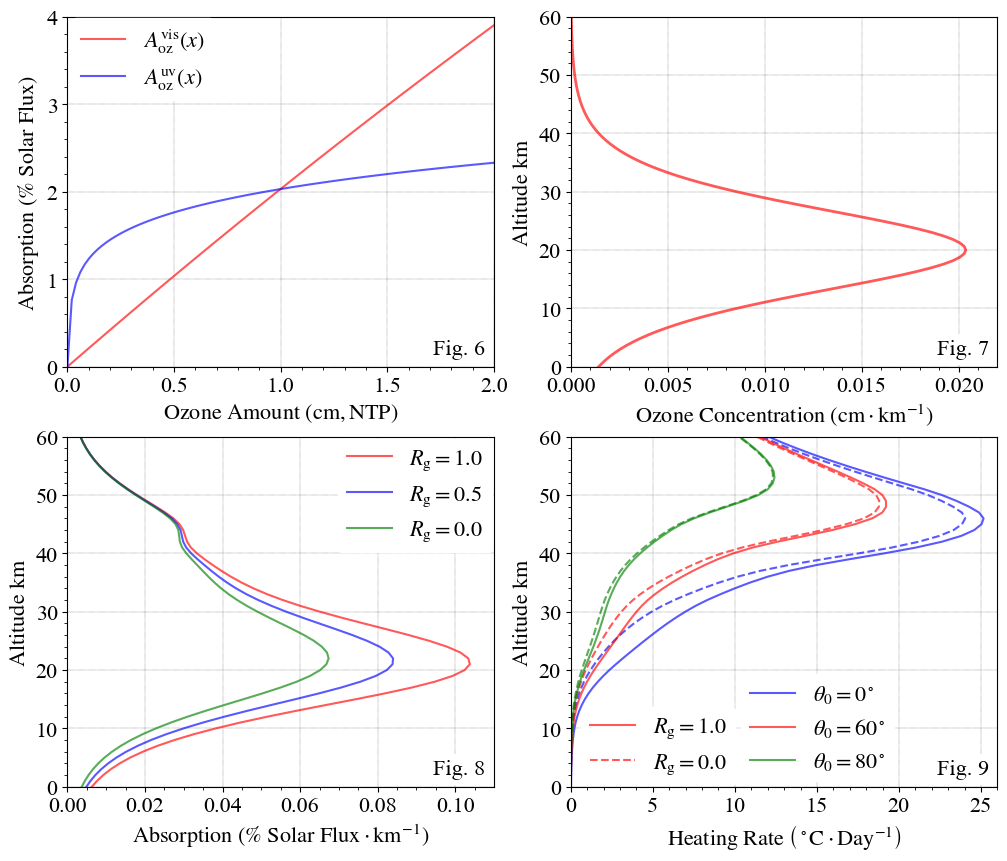

In [45]:
def main() -> None:
    """在同一张画布上进行绘制并保存."""
    # 读取配置文件
    config = get_yaml()
    # 创建画布与子图
    fig = plt.figure(figsize=(12, 10))
    axes = fig.subplots(2, 2)
    # 调整子图间距
    # 这步的顺序其实可以在创建子图之前
    fig.subplots_adjust(wspace=0.18)
    # 绘制并保存
    fig06(axes[0, 0], config)
    fig07(axes[0, 1], config)
    fig08(axes[1, 0], config)
    fig09(axes[1, 1], config)
    fig.savefig("main03.png", bbox_inches="tight")


if __name__ == "__main__":
    main()